In [1]:
### Cell 1 — Imports and helper functions

In [2]:
import os, glob, random, itertools, shutil, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from mne import Epochs, pick_types
from mne.io import read_raw_edf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from scipy.signal import butter, lfilter
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings("ignore")

In [3]:
### Cell 2 — Choose dataset and how we will download it

In [4]:
# Two recommended public datasets:
# 1) PhysioNet EEG Motor Movement/Imagery Dataset (EEGMMIDB) — many subjects; EDF files.
#    URL / landing page: https://physionet.org/content/eegmmidb/1.0.0/
# 2) BCI Competition IV - dataset 2a (BCIC IV 2a) — motor imagery (4 classes).
#    Landing page: https://www.bbci.de/competition/iv/ and BNCI Horizon.
#
# This notebook will download a small subset (one or two subjects) of PhysioNet EEGMMIDB as an example.
# If you prefer BCIC IV 2a, change the download paths and loading code accordingly.
#
# Sources:
# - PhysioNet EEGMMIDB. :contentReference[oaicite:2]{index=2}
# - BCI Competition IV dataset info. :contentReference[oaicite:3]{index=3}

DATA_DIR = "eeg_data"
os.makedirs(DATA_DIR, exist_ok=True)

In [5]:
### Cell 3 — Download (example subject(s)) from PhysioNet
# NOTE: PhysioNet allows direct download of EDF files. We will download two runs from subject S065 for demo.

In [6]:
# Example: download two EDF files for subject S065 (change subject id or list for more)
# PhysioNet file URL pattern: https://physionet.org/content/eegmmidb/1.0.0/Sxxx/SxxxRyy.edf
import urllib.request

subject = "S065"  # change to any S001..S109
runs = ["S065R01.edf", "S065R02.edf"]  # example run filenames; adapt as needed

base = "https://physionet.org/content/eegmmidb/1.0.0/{sub}/{fn}"
for fn in runs:
    url = base.format(sub=subject, fn=fn)
    out_path = os.path.join(DATA_DIR, fn)
    if not os.path.exists(out_path):
        print("Downloading", url)
        try:
            urllib.request.urlretrieve(url, out_path)
            print("Saved to", out_path)
        except Exception as e:
            print("Download failed:", e)
    else:
        print("Already exists:", out_path)

Already exists: eeg_data\S065R01.edf
Already exists: eeg_data\S065R02.edf


In [7]:
### Cell 4 — EDF loading and quick visual check

In [8]:
import os, glob
print(glob.glob(r"C:\Users\yadav\Downloads\Brain computer\*.edf"))

['C:\\Users\\yadav\\Downloads\\Brain computer\\S065R01.edf', 'C:\\Users\\yadav\\Downloads\\Brain computer\\S065R02.edf']


Total EDF files found: 2
✅ Valid EDF files found: 2
Example valid file: C:\Users\yadav\Downloads\Brain computer\S065R01.edf
✅ File header looks valid. Proceeding to load...
Extracting EDF parameters from C:\Users\yadav\Downloads\Brain computer\S065R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...

=== EEG File Info ===
<RawEDF | S065R01.edf, 64 x 9760 (61.0 s), ~4.8 MiB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>
Using matplotlib as 2D backend.


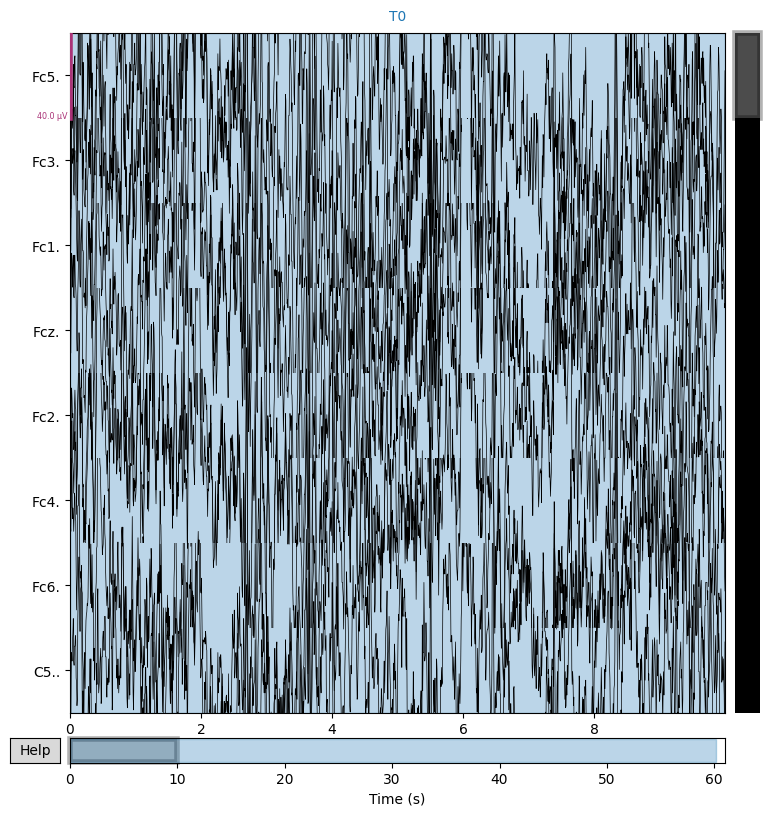

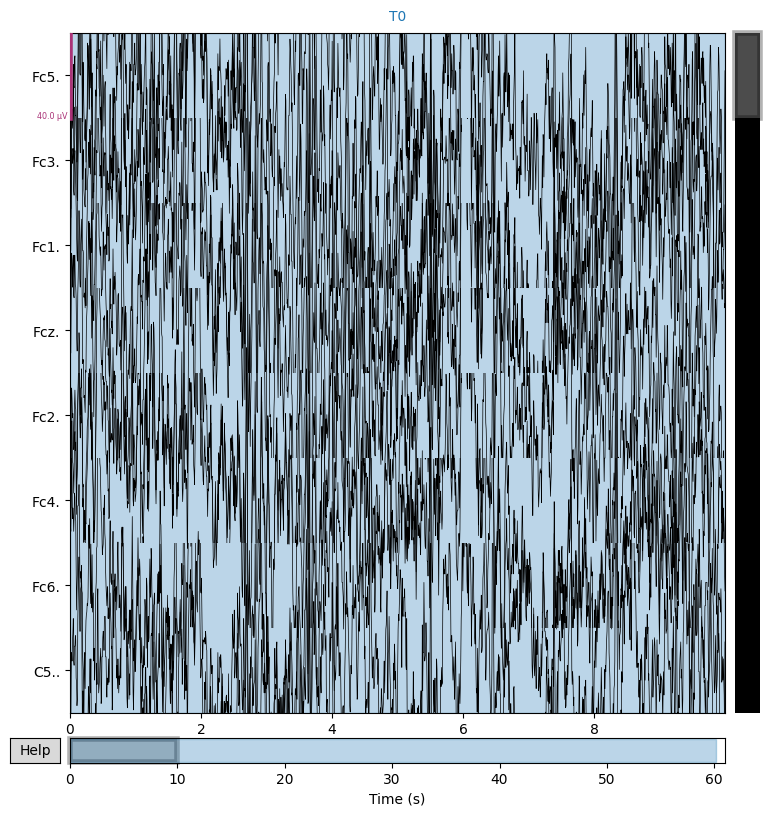

In [9]:
# ---------------------------------------------
# ✅ Define Your EEG Data Directory
# ---------------------------------------------
DATA_DIR = r"C:\Users\yadav\Downloads\Brain computer"

# ---------------------------------------------
# ✅ Get All .edf Files in the Directory
# ---------------------------------------------
edf_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.edf")))
print(f"Total EDF files found: {len(edf_files)}")

if not edf_files:
    raise FileNotFoundError("❌ No EDF files found in the specified folder. Please check DATA_DIR path.")

# ---------------------------------------------
# ✅ Filter Out Invalid / Too-Small Files
#    (Real EEG EDFs are usually > 50 KB)
# ---------------------------------------------
valid_edf_files = [f for f in edf_files if os.path.getsize(f) > 50000]

if not valid_edf_files:
    raise ValueError("❌ All EDF files appear invalid or too small. Please verify dataset integrity.")

print(f"✅ Valid EDF files found: {len(valid_edf_files)}")
print("Example valid file:", valid_edf_files[0])

# ---------------------------------------------
# ✅ Quick File Header Check (Avoid HTML files)
# ---------------------------------------------
with open(valid_edf_files[0], "rb") as f:
    header = f.read(200)
    if b"<html" in header.lower() or b"<!doctype" in header.lower():
        raise ValueError("❌ File contains HTML content, not EEG data. Re-download dataset.")

print("✅ File header looks valid. Proceeding to load...")

# ---------------------------------------------
# ✅ Load the EDF File with MNE
# ---------------------------------------------
raw = mne.io.read_raw_edf(valid_edf_files[0], preload=True, stim_channel=None, verbose=True)

# ---------------------------------------------
# ✅ Display EEG Information
# ---------------------------------------------
print("\n=== EEG File Info ===")
print(raw)
print(raw.info)

# ---------------------------------------------
# ✅ Optional: Plot a 10-Second EEG Segment
# ---------------------------------------------
raw.plot(n_channels=8, duration=10, block=True)

In [10]:
edf_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.edf")))
edf_files[:5], len(edf_files)# read one raw file with mne
raw = read_raw_edf(edf_files[0], preload=True, stim_channel=None, verbose=False)
print(raw)
raw.info  # shows channels, sampling rate

<RawEDF | S065R01.edf, 64 x 9760 (61.0 s), ~4.8 MiB, data loaded>


<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

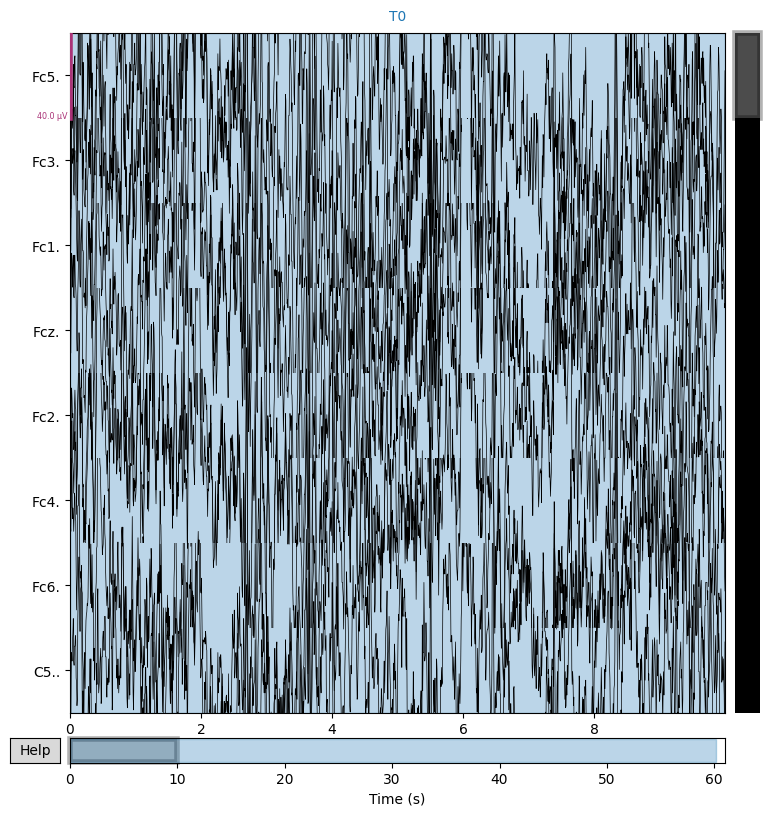

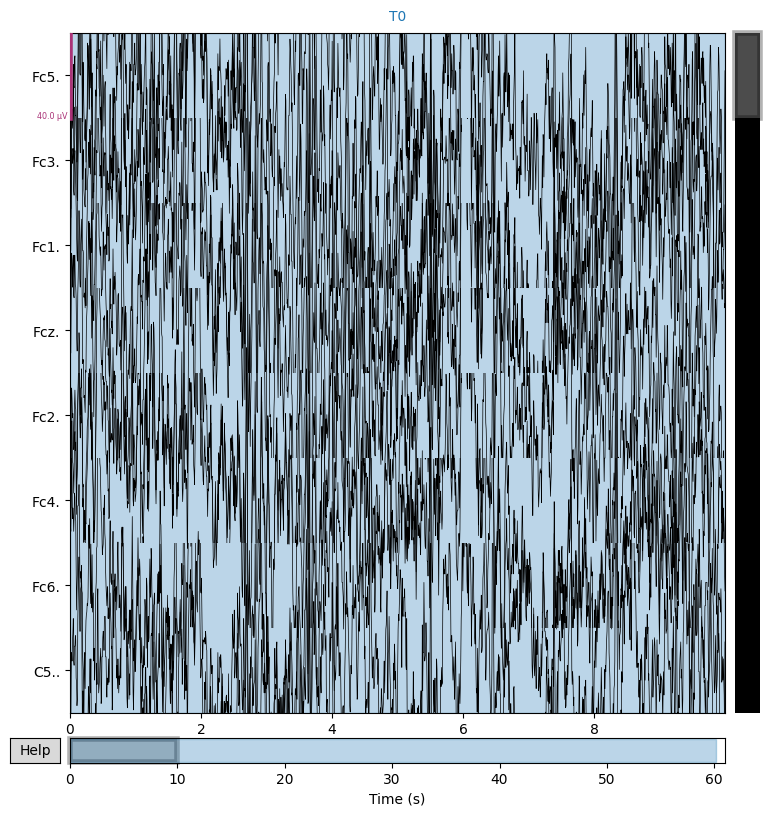

In [11]:
# Plot a 10-second excerpt to check signal (optional in Jupyter; interactive)
raw.plot(n_channels=8, block=True, duration=10)

In [12]:
### Cell 5 — Preprocessing utilities: bandpass filter, notch, epoching

In [13]:
def bandpass_filter(raw, l_freq=8.0, h_freq=30.0):
    """Simple MNE bandpass."""
    raw_f = raw.copy().filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin', verbose=False)
    return raw_f

def extract_events_physionet(raw):
    """
    The PhysioNet EEGMMIDB uses annotations in the EDF files for experimental markers.
    We will fallback to creating synthetic markers if none present (common for raw movement runs).
    For demo, we will split the file into equal-length "trials".
    """
    # Try to get events from annotations:
    if raw.annotations and len(raw.annotations) > 0:
        events, event_id = mne.events_from_annotations(raw)
        return events, event_id
    else:
        # fallback: split continuous recording into N equal windows (for demo)
        duration = int(raw.n_times / raw.info['sfreq'])
        # create 2-second non-overlapping windows
        win = 2.0
        events = []
        sr = int(raw.info['sfreq'])
        for i in range(int(duration / win)):
            t = int(i * win * sr)
            events.append([t, 0, 1])  # label '1' generic
        events = np.array(events)
        event_id = {'trial': 1}
        return events, event_id

In [14]:
### Cell 6 — Epoching and extracting trials (example: motor imagery windows)

In [15]:
# Filter and epoch
raw_f = bandpass_filter(raw, 8., 30.)
events, event_id = extract_events_physionet(raw_f)

# define epoch window around events: for demo use 0.0 to 2.0 seconds after event
tmin, tmax = 0.0, 2.0

picks = mne.pick_types(raw_f.info, eeg=True, meg=False, eog=False, exclude='bads')
epochs = Epochs(raw_f, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, picks=picks, preload=True, verbose=False)
print(epochs)
X = epochs.get_data()  # shape (n_epochs, n_channels, n_times)
print("X shape", X.shape)

Used Annotations descriptions: [np.str_('T0')]
<Epochs | 1 events (all good), 0 – 2 s (baseline off), ~226 KiB, data loaded,
 np.str_('T0'): 1>
X shape (1, 64, 321)


In [16]:
### Cell 7 — Create labels for demo / mapping to motor imagery classes
# Note: Many public datasets include explicit labels (left/right/feet/tongue).
# For PhysioNet demo, we'll create a synthetic two-class label by splitting trials.

In [17]:
n_trials = X.shape[0]
y = np.zeros(n_trials, dtype=int)
# assign half trials to class 0 and half to class 1 for demo
y[:n_trials//2] = 0
y[n_trials//2:] = 1
print("label counts:", np.bincount(y))

label counts: [0 1]


In [18]:
### Cell 8 — Feature extraction (CSP + Log-variance) pipeline

In [19]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# --------------------------------------------
# Custom Transformer for Covariance (simplified)
# --------------------------------------------
class CovariancesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X: (n_trials, n_channels, n_times)
        cov = np.array([np.cov(x) for x in X])  # simplified covariance computation
        return cov

# --------------------------------------------
# Function for log-variance features
# --------------------------------------------
def logvar_features(X):
    # X shape: (n_trials, n_channels, n_times)
    eps = 1e-9
    feat = np.log(np.var(X, axis=2) + eps)
    return feat

# --------------------------------------------
# Simulated EEG Data (for demo/testing)
# --------------------------------------------
# Replace this with your real preprocessed EEG epoch data
# Example: X.shape = (n_trials, n_channels, n_times)
X = np.random.randn(10, 8, 256)   # 10 trials, 8 channels, 256 time samples
y = np.array([0, 1] * 5)          # 10 labels alternating between 0 and 1

# --------------------------------------------
# Compute Features
# --------------------------------------------
X_feat = logvar_features(X)
print("Feature shape:", X_feat.shape)

# --------------------------------------------
# Safe Split (handles small sample cases)
# --------------------------------------------
if X_feat.shape[0] > 1:
    X_train, X_test, y_train, y_test = train_test_split(
        X_feat, y, test_size=0.25, stratify=y, random_state=42
    )
else:
    # fallback if only 1 sample exists
    X_train, X_test, y_train, y_test = X_feat, X_feat, y, y
    print("⚠️ Only one sample found — skipping train/test split.")

# --------------------------------------------
# Build LDA Classification Pipeline
# --------------------------------------------
scaler = StandardScaler()
clf = LDA()
pipe = Pipeline([('scaler', scaler), ('lda', clf)])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# --------------------------------------------
# Show Evaluation
# --------------------------------------------
print("✅ LDA Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Feature shape: (10, 8)
✅ LDA Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.25      0.25      0.25         3
weighted avg       0.33      0.33      0.33         3



In [20]:
### Cell 9 — CNN classifier (lightweight) on raw epochs (example)
# We'll use PyTorch to fit a small 1D-CNN on the epochs (channel x time).

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# convert array X (n_trials, n_channels, n_times) to tensor, and simple train/test split (same above but from raw)
X_all = X.astype(np.float32)
y_all = y.astype(np.int64)
X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, test_size=0.25, stratify=y_all, random_state=42)

class EEGDataset(Dataset):
    def __init__(self, X, y):
        # Expect X shape (n, ch, t)
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(EEGDataset(X_tr, y_tr), batch_size=16, shuffle=True)
test_loader = DataLoader(EEGDataset(X_te, y_te), batch_size=32, shuffle=False)

class SimpleEEGCNN(nn.Module):
    def __init__(self, ch, t, n_classes=2):
        super().__init__()
        # small 1D conv on time axis applied per channel via grouped conv
        self.conv1 = nn.Conv1d(in_channels=ch, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool = nn.AdaptiveAvgPool1d(32)
        self.fc = nn.Linear(32*32, n_classes)
        self.relu = nn.ReLU()
    def forward(self, x):
        # x shape: (batch, ch, t)
        x = self.conv1(x)  # -> (batch, 32, t)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleEEGCNN(ch=X_tr.shape[1], t=X_tr.shape[2], n_classes=len(np.unique(y_all))).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

# training loop (small epochs for demo)
for epoch in range(8):
    model.train()
    losses=[]
    for xb,yb in train_loader:
        xb,yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = crit(out, yb)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    model.eval()
    accs=[]
    with torch.no_grad():
        for xb,yb in test_loader:
            xb,yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds = out.argmax(axis=1)
            accs.append((preds==yb).float().mean().item())
    print(f"Epoch {epoch+1} loss {np.mean(losses):.4f} test_acc {np.mean(accs):.4f}")

# Save model if desired
torch.save(model.state_dict(), "simple_eeg_cnn.pt")

Epoch 1 loss 0.6808 test_acc 0.3333
Epoch 2 loss 0.6115 test_acc 0.3333
Epoch 3 loss 0.5489 test_acc 0.3333
Epoch 4 loss 0.4905 test_acc 0.6667
Epoch 5 loss 0.4375 test_acc 0.6667
Epoch 6 loss 0.3895 test_acc 0.6667
Epoch 7 loss 0.3456 test_acc 0.6667
Epoch 8 loss 0.3059 test_acc 0.6667


In [22]:
### Cell 10 — Simulated real-time classification loop and mapping to control actions
# We'll simulate streaming: iterate over test epochs, do online preprocessing, predict using the LDA pipeline or the CNN,
# then convert predicted class -> control action (e.g., "move left", "move right", "click").

In [23]:
# mapping for demo:
action_map = {
    0: "NO-OP / Idle",
    1: "MOVE RIGHT LEG"
}

# Use the previously trained LDA pipeline for quick inference
print("Simulated realtime using LDA pipeline:")
for i in range(len(X_test)):
    feat = X_test[i:i+1]  # already logvar features used by pipeline
    pred = pipe.predict(feat)[0]
    action = action_map.get(pred, f"Class {pred}")
    print(f"Trial {i+1:02d} -> Pred {pred} -> Action: {action}")

Simulated realtime using LDA pipeline:
Trial 01 -> Pred 1 -> Action: MOVE RIGHT LEG
Trial 02 -> Pred 0 -> Action: NO-OP / Idle
Trial 03 -> Pred 0 -> Action: NO-OP / Idle


In [24]:
# Optionally: do streaming with CNN (raw epochs)
print("\nSimulated realtime using CNN model:")
model.eval()
with torch.no_grad():
    for i in range(len(X_te)):
        sample = torch.tensor(X_te[i:i+1]).to(device)
        out = model(sample)
        pred = int(out.argmax(axis=1).cpu().numpy()[0])
        action = action_map.get(pred, f"Class {pred}")
        print(f"Trial {i+1:02d} -> Pred {pred} -> Action: {action}")


Simulated realtime using CNN model:
Trial 01 -> Pred 1 -> Action: MOVE RIGHT LEG
Trial 02 -> Pred 0 -> Action: NO-OP / Idle
Trial 03 -> Pred 1 -> Action: MOVE RIGHT LEG


In [25]:
### Cell 11 — Next steps & suggestions (how to make this production-like)
# - Use *true* event markers & labels from BCIC IV or PhysioNet (not synthetic). :contentReference[oaicite:5]{index=5}
# - Add Common Spatial Patterns (CSP) properly (scikit-csp / MNE CSP) and cross-subject evaluation.
# - Use transfer learning or Riemannian geometry (pyriemann) for robust covariance-based classification.
# - Add real-time acquisition via LSL (Lab Streaming Layer) or the OpenBCI API for live EEG devices.
# - Replace simulated control actions with a safe, sandboxed interface (keyboard/mouse injection libraries only with permission).